# **(NLP) Sentiment Analysis on Financial News Headlines**

# **Objective**

#### This analysis aims at predicting sentiments from financial news headlines from the perspective of retail investors using various deep learning NLP and traditional supervised machine learning modeling techniques.



## **Dataset**


#### The dataset is composed of 4846 pieces of news headlines that have been assigned three sentiment ratings, which are "Positive"", "Negative" and "Neutral", see below break down:

## **Compare Deep Learning vs Traditional Supervised Learning Machine Learning approach**

### * Multi-classes text classification ML models: through **scikit-learn** library and **NLP packages**
### * Deep Learning: through **TensorFlow and Keras frameworks**

In [ ]:
# Setup Google Colab dev
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Then change directory to the notebook directory.
%cd "/content/drive/My Drive/Colab Notebooks/sentiment_analysis"

/content/drive/My Drive/Colab Notebooks/sentiment_analysis


## Check for GPU resource (Optional)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-358a13f6-4edf-be7a-8806-b4b3523582db)


# **Import python Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import random

from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6
from tensorflow.keras import layers
import tensorflow_hub as hub


from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




#### Enable Display Ipython full output in cells

In [ ]:
#Enable displaying full Ipython output
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
#setup some Tensorflow output options
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# **Load Financial News Sentiment Text Dataset**

### This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

## it contains news text and three sentiment grades:

> -- **Positive**

> -- **Negative**

> -- **Neutral**



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('all-data.csv',delimiter=',',header=None, encoding='latin-1')
df = df.rename(columns={0:'sentiment',1:'text'})
df.head(6)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


# **EDA: Data Exploration and Cleaning**

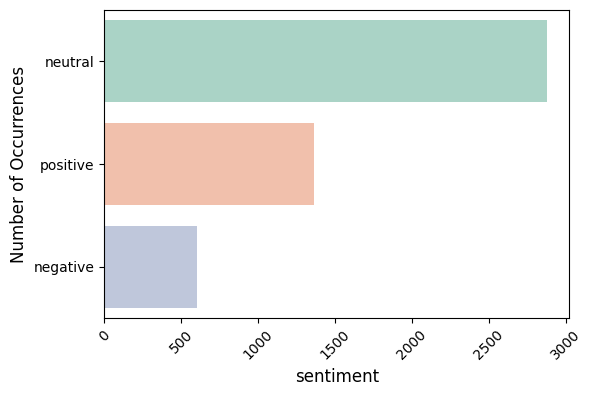

In [ ]:
news_count = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(y = news_count.index, x = news_count.values, alpha=0.6, palette = "Set2",orient='h')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

#### Convert String Labels into numeric values

In [ ]:
#Convert label string to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2}
sentiment
df.sentiment = [sentiment[item] for item in df['sentiment']]

df['sentiment'].value_counts()

1    2879
0    1363
2     604
Name: sentiment, dtype: int64

#### Basic text string clearning

In [ ]:
from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

df['text'] = df['text'].apply(cleanText)

<ipython-input-42-3037184704f0>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [ ]:
### check total word counts after clean up
df.index = range(len(df))
df['text'].apply(lambda x: len(x.split(' '))).sum()

111989

In [ ]:
### check total unique word counts after clean up
df.index = range(len(df))
df['text'].apply(lambda x: len(x.split(' '))).unique().sum()

1855

In [ ]:
### Display a sentence based on row index to verify the content
def print_sentence(index):
    example = df[df.index == index][['text', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('sentiment:', example[1])

display(print_sentence(0))
display(print_sentence(5))

according to gran , the company has no plans to move all production to russia , although that is where the company is growing .
sentiment: 1


None

financing of aspocomp 's growth aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding hdi printed circuit boards pcbs .
sentiment: 0


None

# **Split Initial data into Training and Testing data set**

#### **Side note:** The testing data set will be set aside until the very last of this analysis. The training data will be further split into another training set and validation set for model training and validaiton.

In [ ]:
### Split data into training and validation dataset
train_size = int(4 * len(df) / 5)
display(train_size)

test_size = len(df) - train_size
display(test_size)

3876

970

### Shuffle data so each time we can get different train and test set

In [ ]:
#shffle training data, so we can train on random sentences
import random

random_seed = 42

df_shuffled = df.sample(frac=1, random_state=random_seed)
df_shuffled.head()

train_df = df_shuffled.iloc[0:train_size,:]
test_df = df_shuffled.iloc[train_size:,:]


print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 3876
Total test samples: 970
Total samples: 4846


### Check the labels in Training set



In [ ]:
train_df['sentiment'].value_counts()

1    2290
0    1109
2     477
Name: sentiment, dtype: int64

In [ ]:
train_df.head(5)

,sentiment,text
3207,1,the company was supposed to deliver machinery ...
1684,1,unc charlotte would also deploy ssh tectia con...
1044,1,"in 2009 , lee & man had a combined annual prod..."
4145,1,`` that 's a very high figure on the european ...
1538,1,"in finland , the corresponding service is alma..."


# **Creating Validation Data Set**

#### Subsetting Training set into another training and validation set
#### Randomize sequences of data and shuffling the text messages

In [ ]:
### Split training data into training and validation dataset
import numpy as np
import random


#shffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
#train_df_shuffled.head()

from sklearn.model_selection import train_test_split
X_train_v, X_val, y_train_v, y_val = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['sentiment'].to_numpy(), test_size = 0.2, random_state=100)

# How many samples total?
print(f"Total training samples: {len(X_train_v) + len(X_val)}")

print("++++++++++++++")
print(f"Total training lebels: {len(y_train_v)}")

print("Distribution of training labels")
# Get the unique values and their counts
unique_values, counts = np.unique(y_train_v, return_counts=True)
# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

print("++++++++++++++")
print(f"Total validation labels: {len(y_val)}")
print("Distribution of validation labels")
# Get the unique values and their counts
unique_values, counts = np.unique(y_val, return_counts=True)
# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")


Total training samples: 3876
++++++++++++++
Total training lebels: 3100
Distribution of training labels
0 occurs 876 times
1 occurs 1849 times
2 occurs 375 times
++++++++++++++
Total validation labels: 776
Distribution of validation labels
0 occurs 233 times
1 occurs 441 times
2 occurs 102 times


In [ ]:
### Display a set of shuffled data
num_of_sentences = 3
random_index = random.randint(0, len(train_df)-num_of_sentences)
for row in train_df_shuffled[["text", "sentiment"]][random_index:random_index+num_of_sentences].itertuples():
  _, text, sentiment = row
  print(f"Sentiment:  {sentiment}", "(Positive)" if sentiment == 0  else "(Neutral or negative)")
  print(f"Sentences:  {text}\n")

Sentiment:  1 (Neutral or negative)
Sentences:  kesko has previously published a stock echange release concerning the deal on 7 february 2007 .

Sentiment:  1 (Neutral or negative)
Sentences:  the total restructuring costs are epected to be about eur 30mn , of which eur 13.5 mn was booked in december 2008 .

Sentiment:  2 (Neutral or negative)
Sentences:  the operating margin came down to 2.4 % from 5.7 % .



# **Modeling to Predict Sentiment in the Financial News**

### More specifically, we're addressing the NLP problem by building the follow Text Classification models:

>### **Classic Supervised learning models( Scikit-learn)**
>> #### Model 0: Naive Bayes (baseline)
>> #### Model 1: Random Forest
>> #### Model 2: XGBoost
>> #### Model 3: Support Vector Machine
>> #### Model 4: Logistic Regression

>### **Deep Learning with NLP text preprocessing (TensorFlow/Keras)**
>>#### Model 5: RNNs (LSTM)
>>#### Model 6: TensorFlow Hub Pretrained Feature Extractor (Transfer Learning use USE)

# **Model Performance Metrics**

#### First, create an model evaluation function for our modeling experiments


## **Accuracy, Precision, Recall, F1-score, confusion matrix**
For multi-classes problems, weighted scores will be used.

In [ ]:
# Functions to evaluate models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train results:\n================================================")
        print(f"Accuracy: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Performance:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Results:\n================================================")
        print(f"Accuracy: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Performance:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

## **Confusion Matrix Plot**

In [ ]:
## Display a nicer visualization of confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_confusion_matrix(y_test, y_pred, classifier):

    cm=confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(2,2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()



#### Create and initiate a dictionary to store F1 score so that all models can be compared using the same criteria

In [ ]:
#Initialize a dictionary to store the F1 score for various models
f1_score_metrics = dict()

# **Model 0: Naive Bayes (Baseline)**


In [ ]:
#Model 0 : Naive Bayes (baseline) sklearn Multinomal Naive Bayes using TF-IDF formula to convert the words into numbers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text using ML models
])


# Fit the pipeline to the training data
model_0.fit(X_train_v, y_train_v)

# Evaluate the model using CV score using cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_0, X_train_v, y_train_v, cv=5)
print("Cross-validation scores:", scores)
print("Mean f1 score:", scores.mean())


Cross-validation scores: [0.65       0.67419355 0.67419355 0.68709677 0.67741935]
Mean f1 score: 0.6725806451612903


#### Make a prediction on validation data

In [ ]:
# Make predictions on validation data
y_val_preds = model_0.predict(X_val)
y_val_preds[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Evaluate model performance
>#####  -- Print out performance scores and confusion matrix

In [ ]:
#print_score(y_train, y_train_pred, train=True)
print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 63.92%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.600000    0.643917    1.000000  0.639175    0.747972   
recall       0.257511    0.984127    0.019608  0.639175    0.420415   
f1-score     0.360360    0.778475    0.038462  0.639175    0.392432   
support    233.000000  441.000000  102.000000  0.639175  776.000000   

           weighted avg  
precision      0.677535  
recall         0.639175  
f1-score       0.555663  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[ 60 173   0]
 [  7 434   0]
 [ 33  67   2]]



<Figure size 200x200 with 0 Axes>

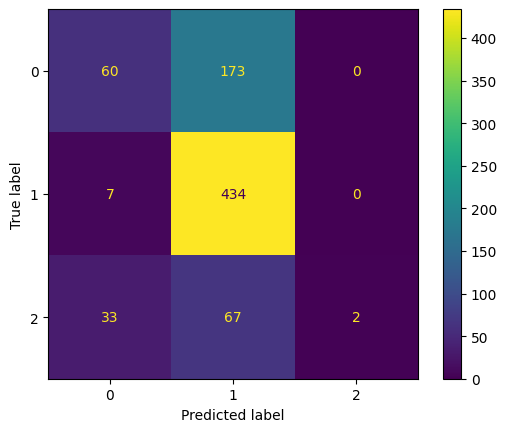

In [ ]:
display_confusion_matrix(y_val, y_val_preds, model_0)

In [ ]:
### save F1 score to f1_score_metrics
f1_score_metrics['Naive Bayes'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}
f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487}}

# **Model 1: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", RandomForestClassifier(n_estimators=100, oob_score=False)) # model the text using ML models
])

# Fit the pipeline to the training data
model_1.fit(X_train_v, y_train_v)

from sklearn.model_selection import cross_val_score

# Evaluate the model using CV score using cross-validation
scores = cross_val_score(model_1, X_train_v, y_train_v, cv=5)
print("Cross-validation(CV) scores:", scores)
print("Mean CV score:", scores.mean())

Cross-validation(CV) scores: [0.73870968 0.75806452 0.72419355 0.75       0.74354839]
Mean CV score: 0.7429032258064516


In [ ]:
# Make predictions on validation data
y_val_preds = model_1.predict(X_val)

In [ ]:
print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 74.61%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.823077    0.718076    0.906977  0.746134    0.816043   
recall       0.459227    0.981859    0.382353  0.746134    0.607813   
f1-score     0.589532    0.829502    0.537931  0.746134    0.652322   
support    233.000000  441.000000  102.000000  0.746134  776.000000   

           weighted avg  
precision      0.774433  
recall         0.746134  
f1-score       0.719124  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[107 124   2]
 [  6 433   2]
 [ 17  46  39]]



In [ ]:
f1_score_metrics['Random Forest'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}

f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487},
 'Random Forest': {'Validation': 0.7191239586179475}}

# **Model 2: XGBoost**

In [ ]:
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_2 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", XGBClassifier()) # model the text using ML models
])

# Fit the pipeline to the training data
model_2.fit(X_train_v, y_train_v)


from sklearn.model_selection import cross_val_score

# Evaluate the model using  CV score using cross-validation
scores = cross_val_score(model_2, X_train_v, y_train_v, cv=5)
print("Cross-validation(CV) scores:", scores)
print("Mean CV score:", scores.mean())



Cross-validation(CV) scores: [0.74677419 0.76612903 0.75967742 0.75806452 0.73870968]
Mean CV score: 0.7538709677419354


In [ ]:
# Make predictions on validation data
y_val_preds = model_2.predict(X_val)

In [ ]:
print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 75.77%
_______________________________________________
Classification Performance:
                    0           1          2  accuracy   macro avg  \
precision    0.747126    0.750923    0.85000  0.757732    0.782683   
recall       0.557940    0.922902    0.50000  0.757732    0.660281   
f1-score     0.638821    0.828077    0.62963  0.757732    0.698843   
support    233.000000  441.000000  102.00000  0.757732  776.000000   

           weighted avg  
precision      0.762806  
recall         0.757732  
f1-score       0.745167  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[130 101   2]
 [ 27 407   7]
 [ 17  34  51]]



In [ ]:
f1_score_metrics['XGBoost'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}

f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487},
 'Random Forest': {'Validation': 0.7191239586179475},
 'XGBoost': {'Validation': 0.745166915841581}}

# **Model 3: Support Vector Machine (Linear Kernel)**

Side note: I also tried Radial kernel in a seperate run (data now shown here), but surprisingly, linear kernel acturally performs better than radial kernel in that run.

In [ ]:
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_3 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", SVC(kernel='linear')) # model the text using ML models
])

# Fit the pipeline to the training data
model_3.fit(X_train_v, y_train_v)


from sklearn.model_selection import cross_val_score

# Evaluate the model using  CV score using cross-validation
scores = cross_val_score(model_3, X_train_v, y_train_v, cv=5)
print("Cross-validation(CV) scores:", scores)
print("Mean CV score:", scores.mean())

Cross-validation(CV) scores: [0.73225806 0.78225806 0.76612903 0.76451613 0.75322581]
Mean CV score: 0.7596774193548388


In [ ]:
# Make predictions on validation data
y_val_preds = model_3.predict(X_val)

print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 74.87%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.725714    0.749536    0.806452  0.748711    0.760567   
recall       0.545064    0.916100    0.490196  0.748711    0.650453   
f1-score     0.622549    0.824490    0.609756  0.748711    0.685598   
support    233.000000  441.000000  102.000000  0.748711  776.000000   

           weighted avg  
precision      0.749865  
recall         0.748711  
f1-score       0.735630  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[127 103   3]
 [ 28 404   9]
 [ 20  32  50]]



In [ ]:
f1_score_metrics['SVC'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}

f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487},
 'Random Forest': {'Validation': 0.7191239586179475},
 'XGBoost': {'Validation': 0.745166915841581},
 'SVC': {'Validation': 0.7356302107214523},
 'LogisticRegression': {'Validation': 0.7178577306585933},
 'RNN-LSTM': {'Validation': 0.7018421558848447}}

# **Model 4: Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_4 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", LogisticRegression(random_state=0)) # model the text using ML models
])

# Fit the pipeline to the training data
model_4.fit(X_train_v, y_train_v)


from sklearn.model_selection import cross_val_score

# Evaluate the model using  CV score using cross-validation
scores = cross_val_score(model_4, X_train_v, y_train_v, cv=5)
print("Cross-validation(CV) scores:", scores)
print("Mean CV score:", scores.mean())


Cross-validation(CV) scores: [0.72419355 0.77741935 0.73709677 0.7516129  0.73387097]
Mean CV score: 0.7448387096774194


In [ ]:
# Make predictions on validation data
y_val_preds = model_4.predict(X_val)

print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 73.97%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.740741    0.730298    0.860465  0.739691    0.777168   
recall       0.515021    0.945578    0.362745  0.739691    0.607782   
f1-score     0.607595    0.824111    0.510345  0.739691    0.647350   
support    233.000000  441.000000  102.000000  0.739691  776.000000   

           weighted avg  
precision      0.750543  
recall         0.739691  
f1-score       0.717858  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[120 111   2]
 [ 20 417   4]
 [ 22  43  37]]



In [ ]:
f1_score_metrics['LogisticRegression'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}

f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487},
 'Random Forest': {'Validation': 0.7191239586179475},
 'XGBoost': {'Validation': 0.745166915841581},
 'SVC': {'Validation': 0.6917051669888689},
 'LogisticRegression': {'Validation': 0.7178577306585933}}




--------------------------

# **Deep Learning Models**

--------------------------


## **Natural Language Process (NLP): Text Preprocessing using TensorFlow/Keras**

## Two important NLP preprocessing steps are conduced before training models:

----------
###  ---   **Tokenization:** Vectorize text, by turning each text into either a sequence of integers or into a vector.
#### In this analysis, I set below parameter values:
>>Limit the data set to the top 10000 words.

>>Set the max number of words = 2 * average_text_length.

----------
###  ---   **Embedding:**  Transforms tokenized text into numbers so that Deep learning models can understand.
#### In this analysis, I either use the TensorFlow/Keras framework to generate embedding layers, or use pretrained embeddings from TensorFlow Hub, with just a few lines of code


----------

In [ ]:
### setup parameters
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6
from tensorflow.keras import layers

### set the Max dictionary words count
MAX_NB_WORDS = 10000 # sets the maximum number of words to consider as features for tokenizer.


### set MAX length in a sentence
train_avg_text_length = round(sum([len(i.split()) for i in X_train_v])/len(X_train_v))
train_avg_text_length
23
MAX_SEQUENCE_LENGTH = train_avg_text_length * 2

### setup number of classes
NUM_CLASSES = 3


display(MAX_NB_WORDS)
display(MAX_SEQUENCE_LENGTH)


10000

46

## **Text Vectorization**

#### **Create Text Vectorization Layer**

In [ ]:
### Tokenize the text and create text vectorize layer
vectorize_layer = TextVectorization(max_tokens=MAX_NB_WORDS ,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=MAX_SEQUENCE_LENGTH,
                                    pad_to_max_tokens=True)

# Fit the text vectorizer to the training text
vectorize_layer.adapt(X_train_v)

## **Embedding**

### **Create custom embedding for each Deep Learning Model**

convert text into numbers

In [ ]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
model_5_embedding = layers.Embedding(input_dim=MAX_NB_WORDS,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=MAX_SEQUENCE_LENGTH,
                                     name="embedding_LSTM")


# **Model 5: Recurrent Neural Network (RNNs)**

>## - **Long short-term memory (LSTM)**



In [ ]:
# Create RNN LSTM model

# Input layer for text data
inputs = layers.Input(shape=(1,), dtype="string")
text_features = vectorize_layer(inputs)    ## add vectorization layer
x = model_5_embedding(text_features)       ## create embedding
lstm_layer = layers.LSTM(64)(x)            ## Add LSTM modeling layer #x = layers.LSTM(64, return_sequences=True)(x)
#relu_layer = layers.Dense(64, activation="relu")(lstm_layer)  #only experimental, but not necessarily need this additional layer
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(lstm_layer)


#### Create LSTM Model
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

### alternative way to create model
#model_5 = tf.keras.Sequential([
#    inputs,
#    vectorize_layer,
#    model_5_embedding
#    lstm_layer,
#    outputs
#])


# Compile the model
model_5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model_5.summary()



Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 46)                0         
 ctorization)                                                    
                                                                 
 embedding_LSTM (Embedding)  (None, 46, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1329603 (5.07 MB)
Trainable params: 1329603 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

#### Fit the model

In [ ]:
# Create directory to save TensorBoard logs
SAVE_DIR = "logs"

# Fit model and supply the validation set
batch_size=32
model_5_history = model_5.fit(X_train_v,
                              y_train_v,
                              epochs= 15,
                              batch_size=batch_size, verbose = 2,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: logs/LSTM/20230909-041153
Epoch 1/15
97/97 - 6s - loss: 0.5034 - accuracy: 0.8087 - val_loss: 0.9057 - val_accuracy: 0.6224 - 6s/epoch - 66ms/step
Epoch 2/15
97/97 - 5s - loss: 0.5809 - accuracy: 0.7332 - val_loss: 1.0815 - val_accuracy: 0.6495 - 5s/epoch - 48ms/step
Epoch 3/15
97/97 - 6s - loss: 0.1642 - accuracy: 0.9581 - val_loss: 1.2018 - val_accuracy: 0.7126 - 6s/epoch - 64ms/step
Epoch 4/15
97/97 - 5s - loss: 0.0778 - accuracy: 0.9832 - val_loss: 1.3058 - val_accuracy: 0.6959 - 5s/epoch - 48ms/step
Epoch 5/15
97/97 - 5s - loss: 0.0576 - accuracy: 0.9881 - val_loss: 1.3781 - val_accuracy: 0.7152 - 5s/epoch - 54ms/step
Epoch 6/15
97/97 - 8s - loss: 0.0464 - accuracy: 0.9910 - val_loss: 1.3280 - val_accuracy: 0.7178 - 8s/epoch - 83ms/step
Epoch 7/15
97/97 - 5s - loss: 0.0548 - accuracy: 0.9874 - val_loss: 1.4722 - val_accuracy: 0.6933 - 5s/epoch - 55ms/step
Epoch 8/15
97/97 - 6s - loss: 0.0368 - accuracy: 0.9919 - val_loss: 1.3537 - val_accuracy: 0.7

In [ ]:
### check the accuracy for training set
train_accr = model_5.evaluate(X_train_v,y_train_v)
print('Training set \n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(train_accr[0],train_accr[1]))

97/97 [==============================] - 1s 13ms/step - loss: 0.0139 - accuracy: 0.9968
Training set 
  Loss: 0.014
  Accuracy: 0.997


In [ ]:
### check the accuracy for validation set
val_accr = model_5.evaluate(X_val,y_val)
print('Validation test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(val_accr[0],val_accr[1]))

25/25 [==============================] - 0s 18ms/step - loss: 1.6205 - accuracy: 0.7139
Validation test set
  Loss: 1.620
  Accuracy: 0.714


#### Plot the loss for all epochs runs on train and validation set

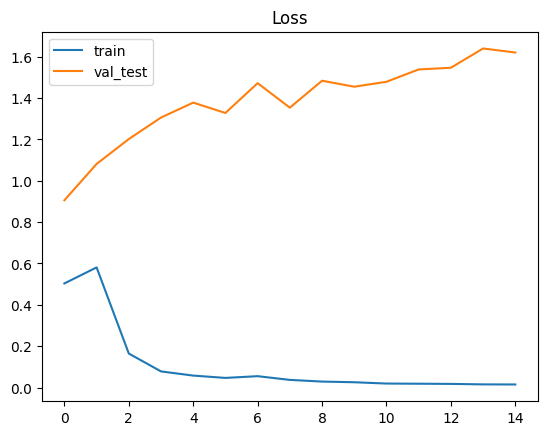

In [ ]:
plt.title('Loss')
plt.plot(model_5_history.history['loss'], label='train')
plt.plot(model_5_history.history['val_loss'], label='val_test')
plt.legend()
plt.show();

Plot the accuracy for all epochs runs on train and validation set

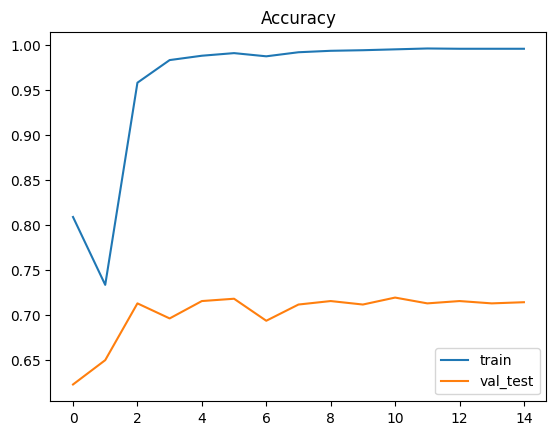

In [ ]:
plt.title('Accuracy')
plt.plot(model_5_history.history['accuracy'], label='train')
plt.plot(model_5_history.history['val_accuracy'], label='val_test')
plt.legend()
plt.show();

#### Make Predictions

In [ ]:
# Make predictions on the validation dataset
y_val_preds_prob = model_5.predict(X_val)
display(y_val_preds_prob[:3]) # view the first 10

y_val_preds = np.argmax(y_val_preds_prob, axis=1)
display(y_val_preds[:30])


25/25 [==============================] - 0s 13ms/step


array([[2.0417960e-04, 9.9966240e-01, 1.3350745e-04],
       [3.0652568e-04, 9.9951750e-01, 1.7592672e-04],
       [2.6882248e-04, 9.9957103e-01, 1.6019031e-04]], dtype=float32)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 2])

#### Print out Model Performance Summary

In [ ]:
print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 71.39%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.646018    0.766376    0.619565  0.713918    0.677319   
recall       0.626609    0.795918    0.558824  0.713918    0.660450   
f1-score     0.636166    0.780868    0.587629  0.713918    0.668221   
support    233.000000  441.000000  102.000000  0.713918  776.000000   

           weighted avg  
precision      0.710940  
recall         0.713918  
f1-score       0.712020  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[146  79   8]
 [ 63 351  27]
 [ 17  28  57]]



#### Store Model F1-scores into dictionary

In [ ]:
f1_score_metrics['RNN-LSTM'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}

f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487},
 'Random Forest': {'Validation': 0.7191239586179475},
 'XGBoost': {'Validation': 0.745166915841581},
 'SVC': {'Validation': 0.7356302107214523},
 'LogisticRegression': {'Validation': 0.7178577306585933},
 'RNN-LSTM': {'Validation': 0.7120197796258214}}

# **Model 6: Using pretrained Embeddings (Transfer Learning for NLP)**

### **Pretrained Embeddings used in this experiment: TensorFlow Hub Pretrained Universal Sentence Encoder (USE)**

For all of the previous deep learning models I've built and trained, i've created and used my own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one larger model has learned from a large amount of data  and adjust it for my particular use case.

So for this model, instead of using our own embedding layer, I replaced it with a pretrained embedding layer - Universal Sentence Encoder from TensorFlow Hub. This embedding creates a whole sentence-level embedding(512 dimensional vector) rather than word-level embedding like we did earlier (128 dimensional vector).


In [ ]:
# We can use this encoding layer in place of our vectorize_layer and embedding layer
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs
                                        dtype=tf.string, # data type of inputs towards USE layer
                                        trainable=False, # keep the pretrained weights
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(1000, activation="relu"),
  layers.Dense(NUM_CLASSES, activation="softmax")
], name="model_6_USE")

model_6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model_6.summary()


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 1000)              513000    
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 257313827 (981.57 MB)
Trainable params: 516003 (1.97 MB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
batch_size = 32
model_6_history = model_6.fit(X_train_v,
                              y_train_v,
                              epochs=12,
                              batch_size=batch_size, verbose = 2,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: logs/tf_hub_sentence_encoder/20230909-043755
Epoch 1/12
97/97 - 6s - loss: 0.7575 - accuracy: 0.6765 - val_loss: 0.6633 - val_accuracy: 0.7023 - 6s/epoch - 61ms/step
Epoch 2/12
97/97 - 3s - loss: 0.5748 - accuracy: 0.7477 - val_loss: 0.6426 - val_accuracy: 0.7165 - 3s/epoch - 31ms/step
Epoch 3/12
97/97 - 3s - loss: 0.5053 - accuracy: 0.7919 - val_loss: 0.6457 - val_accuracy: 0.7178 - 3s/epoch - 30ms/step
Epoch 4/12
97/97 - 2s - loss: 0.4530 - accuracy: 0.8058 - val_loss: 0.6413 - val_accuracy: 0.7216 - 2s/epoch - 18ms/step
Epoch 5/12
97/97 - 2s - loss: 0.3856 - accuracy: 0.8477 - val_loss: 0.6440 - val_accuracy: 0.7255 - 2s/epoch - 18ms/step
Epoch 6/12
97/97 - 2s - loss: 0.3212 - accuracy: 0.8887 - val_loss: 0.6582 - val_accuracy: 0.7320 - 2s/epoch - 18ms/step
Epoch 7/12
97/97 - 2s - loss: 0.2577 - accuracy: 0.9174 - val_loss: 0.6549 - val_accuracy: 0.7397 - 2s/epoch - 18ms/step
Epoch 8/12
97/97 - 2s - loss: 0.2003 - accuracy: 0.9452 - val_loss: 0.6895 

#### Make predictions on validation set

In [ ]:
# Make predictions on the validation dataset
y_val_preds_prob = model_6.predict(X_val)
display(y_val_preds_prob[:3]) # view the first 10

y_val_preds = np.argmax(y_val_preds_prob, axis=1)
display(y_val_preds[:50])

25/25 [==============================] - 1s 14ms/step


array([[4.0852871e-02, 9.5914292e-01, 4.0779528e-06],
       [8.3400168e-02, 9.0496969e-01, 1.1630079e-02],
       [6.4366480e-04, 9.9935633e-01, 1.0330712e-08]], dtype=float32)

array([1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 1, 2,
       1, 0, 0, 0, 1, 1])

#### Plot loss after each epochs run

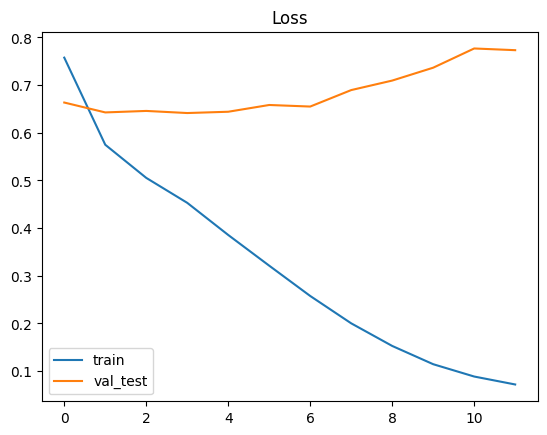

In [ ]:
plt.title('Loss')
plt.plot(model_6_history.history['loss'], label='train')
plt.plot(model_6_history.history['val_loss'], label='val_test')
plt.legend()
plt.show();

#### Plot accuracy after each epochs run

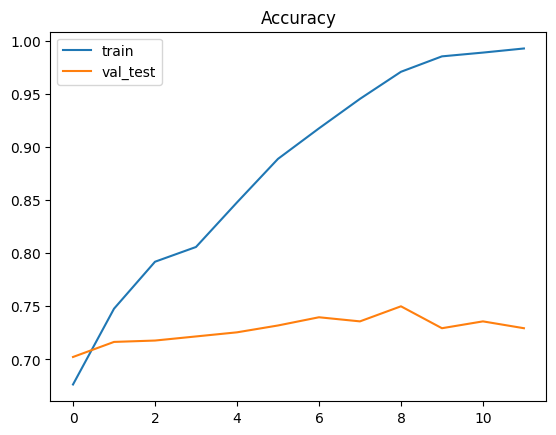

In [ ]:
plt.title('Accuracy')
plt.plot(model_6_history.history['accuracy'], label='train')
plt.plot(model_6_history.history['val_accuracy'], label='val_test')
plt.legend()
plt.show();

#### Print out Model Performance Summary

In [ ]:
print_score(y_val, y_val_preds, train=False)

Test Results:
Accuracy: 72.94%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.636364    0.782881    0.659091  0.729381    0.692779   
recall       0.570815    0.850340    0.568627  0.729381    0.663261   
f1-score     0.601810    0.815217    0.610526  0.729381    0.675851   
support    233.000000  441.000000  102.000000  0.729381  776.000000   

           weighted avg  
precision      0.722617  
recall         0.729381  
f1-score       0.724235  
support      776.000000  
_______________________________________________
Confusion Matrix: 
 [[133  82  18]
 [ 54 375  12]
 [ 22  22  58]]



#### Store F1-score to dictionary

In [ ]:
f1_score_metrics['TF-Hub Pretrained USE'] = {
    'Validation': f1_score(y_val, y_val_preds, average='weighted')
}

f1_score_metrics

{'Naive Bayes': {'Validation': 0.5556632270688487},
 'Random Forest': {'Validation': 0.7191239586179475},
 'XGBoost': {'Validation': 0.745166915841581},
 'SVC': {'Validation': 0.7356302107214523},
 'LogisticRegression': {'Validation': 0.7178577306585933},
 'RNN-LSTM': {'Validation': 0.7120197796258214},
 'TF-Hub Pretrained USE': {'Validation': 0.7242348881865429}}

# **Comparison for all Models(based on F1-score)**

#### Visualize the F-scores for all models on barplot


<Axes: >

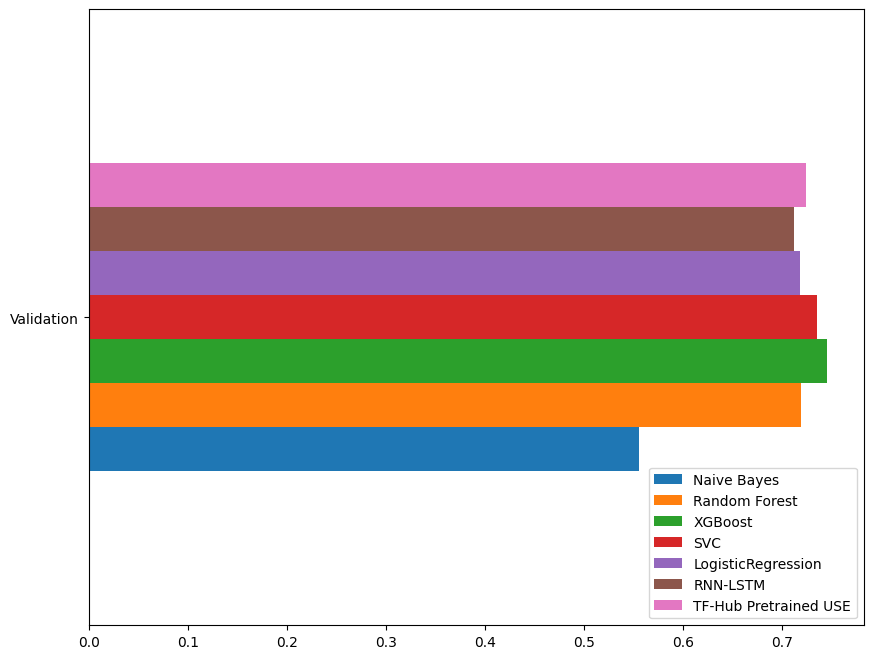

In [ ]:
f1_df = pd.DataFrame(f1_score_metrics)
f1_df.plot(kind='barh', figsize=(10,8))

#### Print out Summary table for F-1 scores for all models

In [ ]:
#Print the F1 score
f1_df

,Naive Bayes,Random Forest,XGBoost,SVC,LogisticRegression,RNN-LSTM,TF-Hub Pretrained USE
Validation,0.555663,0.719124,0.745167,0.73563,0.717858,0.71202,0.724235


# **Insights:**

## Based on F1 score, here are some of the model comparison results:

#### -- Majority of the models can achieve a F1 score in 0.7 - 0.75 range on this small dataset (4000+ news) out of box -- which is not bad but can be bettter, either through supplying more training data or tuning some of the hyper parameters.

#### -- In this analysis, a few classic ML methods such as XGBoost, linear kernel SVC, random forest robustly perform equally well with the  RNN-LSTM method.   

#### -- Tensorflow Hub Pretrained USE model performs somewhat better than RNN-LSTM model here. This is also in line with a seperate analysis I perfored with more complicated datasets, which indicates the pretrained model with sentence level embedding performs overall better than models with custom embedding at word level for this type of text classification.

### **Top 3 models:** : F1 >= 0.72
 --- XGboost  (scikit-learn)

 --- SVC(linear kernel)      (scikit-learn)

 --- TF-Hub Pretrained USE (TensorFlow Hub)


### **followed by**:  0.7 <= F1 < 0.72
 --- Random Forest (scikit-learn)

 --- LogisticRegression  (scikit-learn)

 --- RNN-LSTM  (TensorFlow/Keras)

### **Significant lower performance**: F1 < 0.6

 ---  Naive Bayes (scikit-learn)


In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(X_val, y_val)

25/25 [==============================] - 1s 14ms/step - loss: 0.7731 - accuracy: 0.7294


[0.7731349468231201, 0.7293814420700073]

# **Finally: Making Predictions on the Test Data**


#### Please note: this test data has been set aside earlier. Test data is never been seen by algorithm before up to this point.

#### All Models are trained on training set and validated on validation set but never on this test set, until now.



In [ ]:
test_df.head()

,sentiment,text
201,0,finnish software developer done solutions oyj ...
3208,1,the company will also shut one paper machine i...
1332,1,"sarantel , based in wellingborough , uk , desi..."
3016,1,"( adp news ) - nov 3 , 2008 - finnish paper , ..."
3502,0,according to finnish aktia bank 's managing di...


In [ ]:
test_df.shape

(970, 2)

#### Define a custom function to make a prediction of user supplied random sentences

In [ ]:
def predict_text_sentiment(model, text_df, nr=5):
  """
  Uses model to make a prediction on sentence with sentiment label.

  Returns the sentence, the predicted label and true label and model performance.
  """
  ### Display number of shuffled sentences, nr = number of sentences
  random_index = random.randint(0, len(text_df)-nr)

  for row in train_df_shuffled[["text", "sentiment"]][random_index:random_index+nr].itertuples():
          _, text, sentiment = row
          pred_prob = model.predict([text])
          pred_label = np.argmax(pred_prob, axis=1)
          print(f"Predicted: {pred_label}, Actual: {sentiment} ")
          print(f"Text: {text}\n")

In [ ]:
predict_text_sentiment(model_6, test_df,10)

1/1 [==============================] - 0s 63ms/step
Predicted: [1], Actual: 1 
Text: the bond has a value of eur150m and a maturity of 4 years .

1/1 [==============================] - 0s 72ms/step
Predicted: [1], Actual: 1 
Text: the company plans to spend the proceeds from the rights offering for strengthening its balance sheet .

1/1 [==============================] - 0s 68ms/step
Predicted: [2], Actual: 2 
Text: adpnews - jul 17 , 2009 - finland-based steel maker rautaruukki oyj ruukki hel : rtrks said today it slipped to a net loss of eur 184 million usd 259.7 m for the first half of 2009 from a net profit of eur 2

1/1 [==============================] - 0s 42ms/step
Predicted: [2], Actual: 2 
Text: `` we cut our frequency to new york last year , which eplains the fall , '' he said .

1/1 [==============================] - 0s 50ms/step
Predicted: [1], Actual: 1 
Text: estonia 's agriculture minister helir-valdor seeder is in finland on a two-day visit , in the course of which he w

In [ ]:
test_df.head()

,sentiment,text
201,0,finnish software developer done solutions oyj ...
3208,1,the company will also shut one paper machine i...
1332,1,"sarantel , based in wellingborough , uk , desi..."
3016,1,"( adp news ) - nov 3 , 2008 - finnish paper , ..."
3502,0,according to finnish aktia bank 's managing di...


In [ ]:
test_sentences = test_df['text']
test_sentences = test_sentences.to_numpy()

test_labels = test_df['sentiment']
test_labels = test_labels.to_numpy()

In [ ]:
test_sentences.head()

201     finnish software developer done solutions oyj ...
3208    the company will also shut one paper machine i...
1332    sarantel , based in wellingborough , uk , desi...
3016    ( adp news ) - nov 3 , 2008 - finnish paper , ...
3502    according to finnish aktia bank 's managing di...
Name: text, dtype: object

In [ ]:
test_labels[:10]

201     0
3208    1
1332    1
3016    1
3502    0
2708    1
1934    1
935     0
2418    1
566     0
Name: sentiment, dtype: int64

## Make predictions on all Test data

Please note: Test data is never been seem before during model training and validation

In [ ]:
# Make predictions on the selected test sentences
test_preds_prob = model_6.predict(test_sentences)
display(test_preds_prob[:3])

### generate prediction labels based on probabilty using numpy's argmax function
test_preds = np.argmax(test_preds_prob, axis=1)
display(test_preds[:50])

31/31 [==============================] - 0s 12ms/step


array([[7.3235041e-01, 2.6533723e-01, 2.3123978e-03],
       [9.6836999e-02, 9.0079421e-01, 2.3688127e-03],
       [1.7176474e-02, 9.8253471e-01, 2.8887606e-04]], dtype=float32)

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 0, 1])

In [ ]:
print_score(test_labels, test_preds, train=False)

Test Results:
Accuracy: 74.12%
_______________________________________________
Classification Performance:
                    0           1           2  accuracy   macro avg  \
precision    0.627193    0.805112    0.620690  0.741237    0.684331   
recall       0.562992    0.855688    0.566929  0.741237    0.661870   
f1-score     0.593361    0.829630    0.592593  0.741237    0.671861   
support    254.000000  589.000000  127.000000  0.741237  970.000000   

           weighted avg  
precision      0.734377  
recall         0.741237  
f1-score       0.736727  
support      970.000000  
_______________________________________________
Confusion Matrix: 
 [[143  90  21]
 [ 62 504  23]
 [ 23  32  72]]

